<h3><b>RNA Regression utilizando biblioteca Pytorch</b></h3>
<h4><b>Experimento utilizando técnica cross-validation combinada com tuning de hiperparâmetros.</b></h4>
<p>Utilizaremos base de dados grande.</p>

In [47]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(123)

<h4><b>Carregando dados</b></h4>

In [4]:
path = '/media/marcos/500GB/00_datasets/post_processing/post_processing_dataset.csv'
df = pd.read_csv(path)

In [5]:
df = df[[
    'line_category',
    'line_color',
    'station_initial_latitude',
    'station_initial_longitude',
    'station_final_latitude',
    'station_final_longitude',
    'distance',
    'average_speed_kh',
    'duration'
]]

In [6]:
df

,line_category,line_color,station_initial_latitude,station_initial_longitude,station_final_latitude,station_final_longitude,distance,average_speed_kh,duration
0,1,1,-25.406891,-49.252828,-25.433741,-49.270292,5100.000000,20.400000,900.000000
1,8,5,-25.433741,-49.270292,-25.396167,-49.358341,17300.000000,38.444444,1620.000000
2,1,1,-25.396167,-49.358341,-25.435187,-49.271813,11300.000000,24.214286,1680.000000
3,2,2,-25.435187,-49.271813,-25.436659,-49.273807,1100.000000,16.500000,240.000000
4,2,2,-25.436659,-49.273807,-25.435052,-49.275876,2000.000000,15.000000,480.000000
...,...,...,...,...,...,...,...,...,...
12367,7,6,-25.424410,-49.295560,-25.494404,-49.282068,10500.000000,25.200000,1500.000000
12368,6,5,-25.494404,-49.282068,-25.475952,-49.240087,6200.000000,26.571429,840.000000
12369,7,6,-25.475952,-49.240087,-25.459501,-49.271815,5100.000000,25.500000,720.000000
12370,3,3,-25.459501,-49.271815,-25.440706,-49.271456,2500.000000,25.000000,360.000000


<h4><b>Atribuindo valores as variáveis X e y</b></h4>

In [23]:
X = df.iloc[:,0:8].values
y = df.iloc[:,8].values

In [24]:
X.shape

(12372, 8)

In [25]:
y.shape

(12372,)

<h4><b>Convertendo em tensores Pytorch</b></h4>
<p>view: Redefine as dimensões</p>

In [26]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1,1)

In [27]:
type(X)

torch.Tensor

<h4><b>Confirmando se a variável y está em formato de matriz</b></h4>

In [28]:
y.shape

torch.Size([12372, 1])

<h4><b>Divisão em treino e teste</b></h4>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<h4><b>Construção do modelo da rede neural</b></h4>
<p>Efetuamos este cálculo visando inicializar a quantidade de neurônios nas camadas ocultas da rede neural.</p>
<p>(entradas + saidas) / 2</p>

<ul>
    <li>Entrada: 8</li>
    <li>Camada oculta: 4 neurônios</li>
    <li>Camada oculta: 4 neurônios</li>
    <li>Camada de saída 1 neurônios</li>
</ul>

In [30]:
regressor = nn.Sequential(
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)

<h4><b>Configurando Hiperparâmetros</b></h4>

In [ ]:
# Parâmetros encontrados pela Grid Search
# {'batch_size': 64,
#  'criterion': torch.nn.modules.loss.SmoothL1Loss,
#  'max_epochs': 100,
#  'optimizer__lr': 0.01}

In [31]:
epochs = 100
batch_size = 64
learning_rate = 0.01
criterion = torch.nn.SmoothL1Loss(reduction='mean')
optimizer = optim.Adam(regressor.parameters(), lr=learning_rate)

<h4><b>Inicializando variáveis responsáveis de armazenar histórico das métricas</b></h4>

In [32]:
loss_list = []
mae_list = []
mse_list = []
rmse_list = []
r2_list = []

<h4><b>Preparando o dataset</b></h4>

In [33]:
dataset = TensorDataset(X_train, y_train)

<h4><b>Configurando cross-validation</b></h4>

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

<h4><b>Treinamento</b></h4>

In [35]:
mae_per_fold = []
mse_per_fold = []
rmse_per_fold = []
loss_per_fold = []
r2_per_fold = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Treinando fold {fold + 1}...")
    
    # Dividindo dataset em treino e validação
    train_subsampler = torch.utils.data.Subset(dataset, train_idx)
    val_subsampler = torch.utils.data.Subset(dataset, val_idx)
    
    # DataLoaders e processamento dos batches
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)
    
    # Inicializando o modelo
    model = regressor
    
    # Loss e optimizer
    optimizer = optimizer

    epoch_mae = []
    epoch_mse = []
    epoch_rmse = []
    epoch_losses = []
    epoch_r2 = []
    
    # Loop de treinamento em cada fold
    for epoch in range(epochs):
        running_mae = 0.
        running_mse = 0.
        running_rmse = 0.
        running_loss = 0.
        
        # Treinando cada época
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()

            # Fazendo as previsões, função forward passa os dados para frente
            # Nesta variável teremos o resultado da última camada
            outputs = model.forward(inputs)
            
            # Calculando loss e metrics
            mae = F.l1_loss(outputs, labels, reduction='sum').item()
            mse = F.mse_loss(outputs, labels, reduction='sum').item()
            rmse = np.sqrt(mse)
            loss = criterion(outputs, labels)
            
            # Inicia processo de backpropagation
            # Volta a estrutura da rede neural, fazendo a atualização dos pesos
            loss.backward()

            # Atualiza os pesos
            optimizer.step()
            
            # Acumulando métricas
            running_mae += mae
            running_mse += mse
            running_rmse += rmse
            running_loss += loss.item()

        # Média das métricas ao longo da época
        mae_res = running_mae / len(train_loader.dataset)
        mse_res = running_mse / len(train_loader.dataset)
        rmse_res = running_rmse / len(train_loader.dataset)
        loss_res = running_loss / len(train_loader.dataset)

        epoch_mae.append(mae_res)
        epoch_mse.append(mse_res)
        epoch_rmse.append(rmse_res)
        epoch_losses.append(loss_res)

        # Calculando R2 score
        val_outputs = model(val_loader.dataset[:][0])
        rss = torch.sum((val_loader.dataset[:][1] - val_outputs) ** 2).item()
        tss = torch.sum((val_loader.dataset[:][1] - val_loader.dataset[:][1].mean()) ** 2).item()
        r2_score = 1 - (rss / tss)

        epoch_r2.append(r2_score)

        # Armazenando os resultados
        mae_list.append(mae_res)
        mse_list.append(mse_res)
        rmse_list.append(rmse_res)
        loss_list.append(loss_res)
        r2_list.append(r2_score)
        
        # Print metricas de cada época
        print(f"Epoch {epoch + 1}/{epochs}, MAE: {mae_res:.4f}, MSE: {mse_res:.4f}, RMSE: {rmse_res:.4f}, Loss: {loss_res:.4f}, R2 Score: {r2_score:.4f}")
            
    mae_per_fold.append(epoch_mae)
    mse_per_fold.append(epoch_mse)
    rmse_per_fold.append(epoch_rmse)
    loss_per_fold.append(epoch_losses)
    r2_per_fold.append(epoch_r2)

# Após cross-validation: Média dos resultados
avg_mae = np.mean(mae_list)
avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_loss = np.mean(loss_list)
avg_r2 = np.mean(r2_list)

print(f"\nResultados Cross-validation (média ao longo de {kf.get_n_splits()} folds):")
print(f"MAE: {avg_mae:.4f}")
print(f"MSE: {avg_mse:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"Loss: {avg_loss:.4f}")
print(f"R2 Score: {avg_r2:.4f}")

Treinando fold 1...
Epoch 1/100, MAE: 457.4480, MSE: 439570.4901, RMSE: 70.4680, Loss: 7.1510, R2 Score: 0.5605
Epoch 2/100, MAE: 269.3808, MSE: 137726.4049, RMSE: 45.9229, Loss: 4.2100, R2 Score: 0.6015
Epoch 3/100, MAE: 241.0264, MSE: 106856.4230, RMSE: 40.3995, Loss: 3.7669, R2 Score: 0.6856
Epoch 4/100, MAE: 206.5169, MSE: 73630.5986, RMSE: 33.5937, Loss: 3.2263, R2 Score: 0.8200
Epoch 5/100, MAE: 183.2865, MSE: 57574.3011, RMSE: 29.7834, Loss: 2.8626, R2 Score: 0.8268
Epoch 6/100, MAE: 176.7218, MSE: 55370.8105, RMSE: 29.1694, Loss: 2.7594, R2 Score: 0.8374
Epoch 7/100, MAE: 164.4655, MSE: 48142.2561, RMSE: 27.3013, Loss: 2.5679, R2 Score: 0.8591
Epoch 8/100, MAE: 161.8377, MSE: 46903.7622, RMSE: 26.9135, Loss: 2.5262, R2 Score: 0.8598
Epoch 9/100, MAE: 158.1672, MSE: 44819.6532, RMSE: 26.2814, Loss: 2.4707, R2 Score: 0.8490
Epoch 10/100, MAE: 156.8651, MSE: 44030.3604, RMSE: 25.9337, Loss: 2.4476, R2 Score: 0.8740
Epoch 11/100, MAE: 144.0807, MSE: 36457.6915, RMSE: 23.7267, Loss:

In [36]:
def plotMetricOverFolds(metric, metric_list):
    for fold, metrics in enumerate(metric_list):
        plt.plot(metrics, label=f'Fold {fold + 1}')
    plt.xlabel('Épocas')
    plt.ylabel(metric)
    plt.title(f'{metric} ao longo das épocas de cada fold')
    plt.legend()
    plt.show()

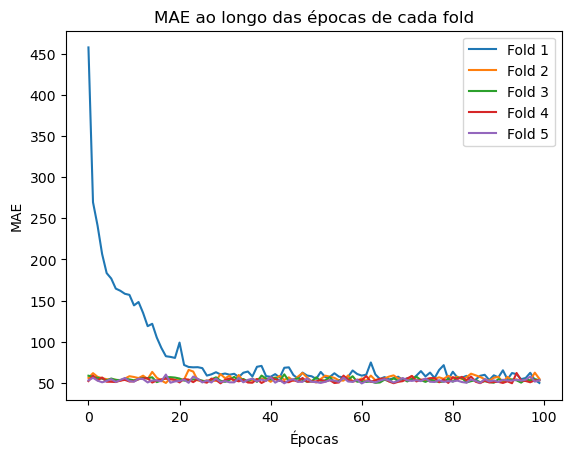

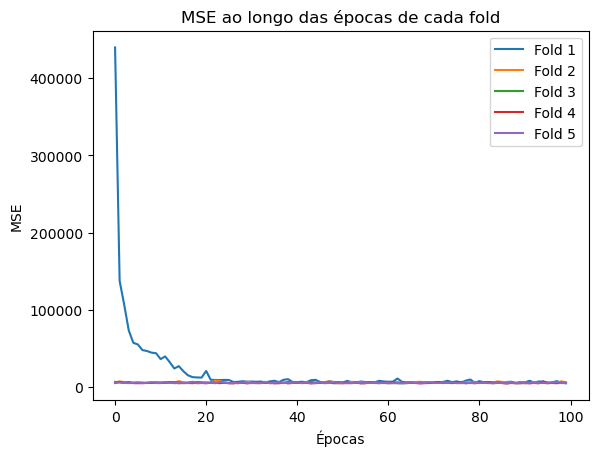

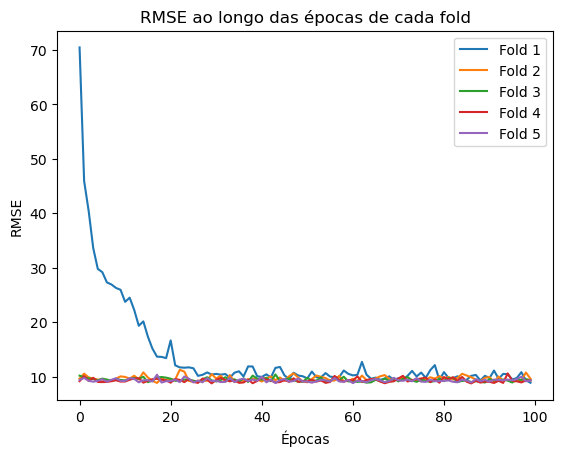

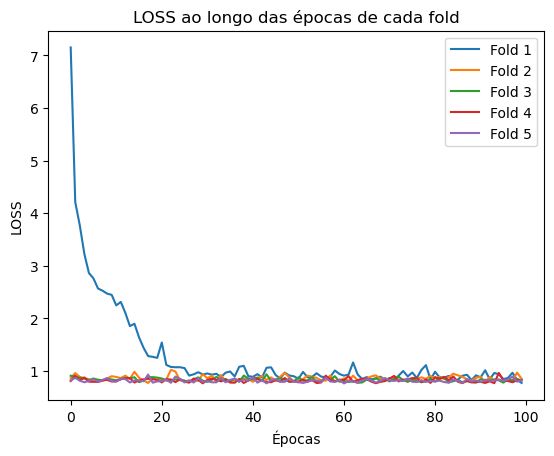

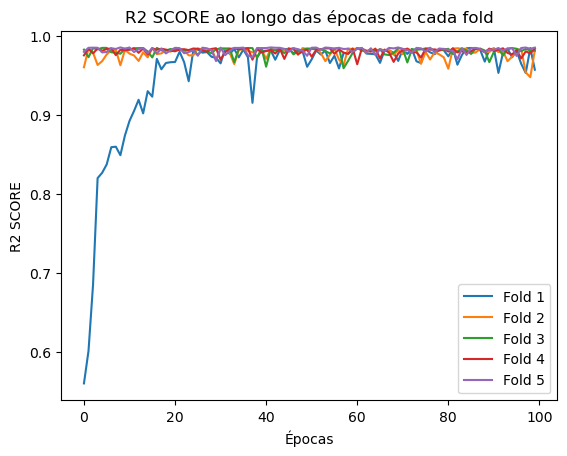

In [37]:
plotMetricOverFolds('MAE', mae_per_fold)
plotMetricOverFolds('MSE', mse_per_fold)
plotMetricOverFolds('RMSE', rmse_per_fold)
plotMetricOverFolds('LOSS', loss_per_fold)
plotMetricOverFolds('R2 SCORE', r2_per_fold)

<h4><b>Calculando métricas no dataset de treino</b></h4>

In [38]:
model.eval()

with torch.no_grad():
    y_pred_tensor_train = model(X_train).squeeze()
    y_train_tensor = y_train.squeeze()

In [56]:
mae_train = F.l1_loss(y_pred_tensor_train, y_train_tensor).item()
mape_train = mean_absolute_percentage_error(y_train_tensor, y_pred_tensor_train).item()
mse_train = F.mse_loss(y_pred_tensor_train, y_train_tensor).item()
rmse_train = np.sqrt(mse_train)
rss_train = torch.sum((y_train_tensor - y_pred_tensor_train) ** 2).item()
tss_train = torch.sum((y_train_tensor - y_pred_tensor_train.mean()) ** 2).item()
r2_train = 1 - (rss_train / tss_train)

print(f'MAE Train: {mae_train:.4f}')
print(f'MAPE Train: {mape_train:.4f}')
print(f'MSE Train: {mse_train:.4f}')
print(f'RMSE Train: {rmse_train:.4f}')
print(f'R2 Train: {r2_train:.4f}')

MAE Train: 45.8815
MAPE Train: 0.0523
MSE Train: 4564.7407
RMSE Train: 67.5629
R2 Train: 0.9846


<h4><b>Calculando métricas no dataset de teste</b></h4>

In [57]:
model.eval()

with torch.no_grad():
    y_pred_tensor = model(X_test).squeeze()
    y_test_tensor = y_test.squeeze()

In [58]:
mae_test = F.l1_loss(y_pred_tensor, y_test_tensor).item()
mape_test = mean_absolute_percentage_error(y_test_tensor, y_pred_tensor).item()
mse_test = F.mse_loss(y_pred_tensor, y_test_tensor).item()
rmse_test = np.sqrt(mse_test)
rss = torch.sum((y_test_tensor - y_pred_tensor) ** 2).item()
tss = torch.sum((y_test_tensor - y_pred_tensor.mean()) ** 2).item()
r2 = 1 - (rss / tss)

print(f'MAE: {mae_test:.4f}')
print(f'MAPE: {mape_test:.4f}')
print(f'MSE: {mse_test:.4f}')
print(f'RMSE: {rmse_test:.4f}')
print(f'R2: {r2:.4f}')

MAE: 45.5815
MAPE: 0.0541
MSE: 4541.7295
RMSE: 67.3924
R2: 0.9843
